<a href="https://colab.research.google.com/github/shainedl/Papers-Colab/blob/master/Autoencoding_Variational_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on *Auto-Encoding Variational Bayes* by Diederick P Kigma and Max Welling (Machine Learning Group, Universiteit van Amsterdam)

In [0]:
import torch
from torch import nn, optim
import torchvision 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [0]:
class VAE(nn.Module):
  def __init__(self, input_size, hidden_units, N_z):
    super(VAE, self).__init__()
    
    self.fc1 = nn.Linear(input_size, hidden_units)
    self.fc21 = nn.Linear(hidden_units, N_z)
    self.fc22 = nn.Linear(hidden_units, N_z)
    self.fc3 = nn.Linear(N_z, hidden_units)
    self.fc4 = nn.Linear(hidden_units, input_size)
    
    self.input_size = input_size
  
  def encode(self, x):
    """
    According to Appendix C.2
    """
    h_e  = torch.tanh(self.fc1(x.view(-1,self.input_size)))
    mu = self.fc21(h_e)
    logvar = self.fc22(h_e)
    
    return mu, logvar
  
  def decode(self, z):
    """
    According to Appendix C.1
    """
    h_d = torch.tanh(self.fc3(z))
    
    return torch.sigmoid(self.fc4(h_d))
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.__reparameterize(mu, logvar)
    
    return self.decode(z), mu, logvar
  
  def __reparameterize(self, mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    
    return mu + std * eps
    

In [0]:
def loss_function(mu, logvar, y, x):
  """
  KL according to Appendix B
  """
  KL = torch.sum(1 + logvar - mu**2 - torch.exp(logvar)) / 2
  
  RE = F.binary_cross_entropy(y, x.view(-1,784), reduction = 'sum')
  
  elbo = KL - RE
  loss = -1 * elbo
  
  return loss

In [0]:
def train(num_epochs):
  
  model.train()
  
  for epoch in range(num_epochs):
    
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
      inputs, labels = data
      
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      y, mu, logvar = model(inputs)
      loss = loss_function(mu, logvar, y, inputs)
      loss.backward()
      optimizer.step()
      
      # print statistics
      running_loss += loss.item()
      if batch_idx % 50 == 49:    # print every 100 mini-batches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 100))
        running_loss = 0.0
            
  print('Finished Training')          
      

In [6]:
batch_size = 100
"""
https://nextjournal.com/gkoehler/pytorch-mnist
Remove the normalization to create Bernoulli data
"""
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 4291061.58it/s]                             


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57455.55it/s]                           
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


1654784it [00:01, 969717.43it/s]                             
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


8192it [00:00, 21767.07it/s]            

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


In [25]:
len(train_loader)

600

In [0]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [8]:
example_data[0].size()

torch.Size([1, 28, 28])

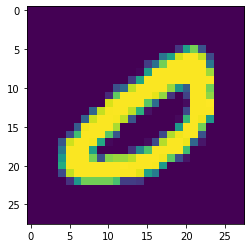

In [13]:
plt.imshow(example_data[0].view(28,28).detach().numpy())

In [30]:
# input_size = 28 * 28 = 784
model = VAE(784, 500, 20)
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
train(20)

[1,    50] loss: 11679.886
[1,   100] loss: 8774.000
[1,   150] loss: 8238.921
[1,   200] loss: 7801.225
[1,   250] loss: 7502.126
[1,   300] loss: 7369.001
[1,   350] loss: 7210.099
[1,   400] loss: 7031.858
[1,   450] loss: 6965.552
[1,   500] loss: 6805.167
[1,   550] loss: 6836.304
[1,   600] loss: 6731.856
[2,    50] loss: 6676.394
[2,   100] loss: 6530.904
[2,   150] loss: 6596.901
[2,   200] loss: 6516.667
[2,   250] loss: 6514.283
[2,   300] loss: 6481.487
[2,   350] loss: 6479.088
[2,   400] loss: 6441.995
[2,   450] loss: 6408.730
[2,   500] loss: 6398.353
[2,   550] loss: 6379.744
[2,   600] loss: 6350.053
[3,    50] loss: 6321.709
[3,   100] loss: 6303.748
[3,   150] loss: 6358.791
[3,   200] loss: 6308.154
[3,   250] loss: 6354.762
[3,   300] loss: 6300.133
[3,   350] loss: 6280.761
[3,   400] loss: 6292.411
[3,   450] loss: 6253.002
[3,   500] loss: 6261.211
[3,   550] loss: 6254.182
[3,   600] loss: 6239.087
[4,    50] loss: 6243.707
[4,   100] loss: 6240.882
[4,   150] 

In [0]:
sample = torch.randn(1, 20)
sample = model.decode(sample)

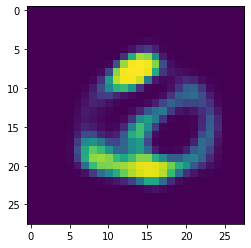

In [35]:
import matplotlib.pyplot as plt
plt.imshow(sample.view(28,28).detach().numpy())